In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
country_df = pd.read_csv("data/country_data.csv", encoding="latin-1")
country_df.head()

,Economy,Code,Region,Income group,Lending category,Other
0,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
1,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
2,Algeria,DZA,Middle East & North Africa,Upper middle income,IBRD,NaN
3,American Samoa,ASM,East Asia & Pacific,Upper middle income,..,NaN
4,Andorra,AND,Europe & Central Asia,High income,..,NaN


<IPython.core.display.Javascript object>

In [3]:
def addIndicatorToMainTable(df, wb_df, indicator_df, short_code):

    df.dropna(axis=1, how="all", inplace=True)

    # add to indicator table
    indicator_cols = ["Indicator Name", "Indicator Code"]
    indic_df = df[indicator_cols].drop_duplicates()
    indic_df["Indicator Short Code"] = short_code
    indicator_df = indicator_df.append(indic_df, sort=False)

    # melt table
    df.drop(columns=indicator_cols, inplace=True)
    df_m = df.melt(
        id_vars=["Country Name", "Country Code"], var_name="year", value_name=short_code
    )

    # add to main table
    if len(wb_df.columns) == 2:
        wb_df = wb_df.merge(df_m, on=["Country Name", "Country Code"], how="outer")
    else:
        wb_df = wb_df.merge(
            df_m, on=["Country Name", "Country Code", "year"], how="outer"
        )
    return wb_df, indicator_df

<IPython.core.display.Javascript object>

In [4]:
indicator_list = ["GDP.MKTP", "GDP.PCAP", "CO2E.KT", "CO2E.PC", "GHGT.KT"]

<IPython.core.display.Javascript object>

In [5]:
indicator_df = pd.DataFrame(
    columns=["Indicator Name", "Indicator Code", "Indicator Short Code"]
)

# loop through tables and create wb_df and inidicator_df tables
for indic in indicator_list:
    for folder in os.listdir("data"):
        if indic in folder and "zip" not in folder:
            # print(folder)
            for file in os.listdir("data/" + folder):
                # print(file)
                df = pd.read_csv("data/{}/{}".format(folder, file), skiprows=4)
                # create wb_df if doesnt exist
                if "wb_df" not in locals():
                    wb_df = df[["Country Name", "Country Code"]]
                wb_df, indicator_df = addIndicatorToMainTable(
                    df, wb_df, indicator_df, short_code=indic
                )
                break

# convert_year to int
wb_df["year"] = wb_df["year"].astype("int")

<IPython.core.display.Javascript object>

In [6]:
# sort values by country and year
wb_df.sort_values(by=["Country Name", "year"], inplace=True)

<IPython.core.display.Javascript object>

In [7]:
## save wb_df and indicator_df
wb_df.to_csv("data/co2_gdp_wb.csv", index=False)
indicator_df.to_csv("data/indicators.csv", index=False)

<IPython.core.display.Javascript object>

In [8]:
indicator_df

,Indicator Name,Indicator Code,Indicator Short Code
0,"GDP, PPP (current international $)",NY.GDP.MKTP.PP.CD,GDP.MKTP
0,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,GDP.PCAP
0,CO2 emissions (kt),EN.ATM.CO2E.KT,CO2E.KT
0,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,CO2E.PC
0,Total greenhouse gas emissions (kt of CO2 equi...,EN.ATM.GHGT.KT.CE,GHGT.KT


<IPython.core.display.Javascript object>

In [9]:
## get only countries (country codes) and data from 1990
wb_df = (
    wb_df.loc[
        (wb_df["Country Code"].isin(list(country_df["Code"]))) & (wb_df["year"] >= 1990)
    ]
    .sort_values(by="year")
    .reset_index(drop=True)
)
wb_df.head()

,Country Name,Country Code,year,GDP.MKTP,GDP.PCAP,CO2E.KT,CO2E.PC,GHGT.KT
0,Afghanistan,AFG,1990,NaN,NaN,2614.571,0.210643,1.252802e+04
1,"Venezuela, RB",VEN,1990,1.862539e+11,9486.936761,122162.438,6.222407,2.101026e+05
2,Argentina,ARG,1990,2.407294e+11,7380.115031,112147.861,3.438151,2.665550e+05
3,Nigeria,NGA,1990,2.076502e+11,2180.914504,39196.563,0.411675,1.632742e+05
4,Germany,DEU,1990,1.542829e+12,19423.019762,NaN,NaN,1.256074e+06


<IPython.core.display.Javascript object>

In [10]:
def CO2vsGDPGraphs(cntry_code):
    """
    create and save fig with GDP and CO2 emissions data
    """
    cntry_df = wb_df.loc[wb_df["Country Code"] == cntry_code].reset_index(drop=True)
    cntry_name = cntry_df["Country Name"].unique().item()

    fig = plt.figure()
    ax = plt.axes()

    ax.plot(cntry_df["year"], cntry_df["CO2E.PC"], color="r")
    ax.set_ylabel("CO2 emissions per capita (ton)", color="r")

    ax2 = ax.twinx()
    ax2.plot(cntry_df["year"], cntry_df["GDP.PCAP"], color="b")
    ax2.set_ylabel("GDP per capita (current US$ - PPP)", color="b")
    ax.set_xticks(cntry_df.loc[::5, "year"])
    fig.text(0.9, 0.01, "source: World Bank", ha="right")
    fig.text(
        0.5,
        0.95,
        "{} CO2 Emissions and GDP per capita".format(cntry_name),
        weight="bold",
        size=14,
        ha="center",
    )
    #     fig.savefig(
    #         "graphs/{}_CO2_GDP_PCAP.jpg".format(cntry_code), dpi=200, bbox_inches="tight"
    #     )
    plt.close("all")

    return fig
    # plt.show()

<IPython.core.display.Javascript object>

In [11]:
## get 50 countries with highest total GDP in latest year (2018)
top50gdp = (
    wb_df.loc[wb_df.year == wb_df.year.max()]
    .sort_values(by="GDP.MKTP", ascending=False)
    .reset_index(drop=True)
    .iloc[0:50]
)
# top50gdp["Country Code"]

<IPython.core.display.Javascript object>

In [111]:
#export graphs for top50gdp countries
for cntry_code in top50gdp["Country Code"]:
    CO2vsGDPGraphs(cntry_code)

<IPython.core.display.Javascript object>

# Holoviews

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
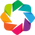

<IPython.core.display.Javascript object>

In [30]:
import holoviews as hv, panel as pn, param

hv.extension("matplotlib", "bokeh")

In [71]:
class CO2GDPhv(param.Parameterized):
    country_name = param.Selector(
        default="United States", objects=wb_df["Country Name"].unique()
    )
    cntry_code = param.Selector(default="USA", objects=wb_df["Country Code"].unique())

    @pn.depends("cntry_code")
    def pnCO2_GDP_PCAP(self, view_fn=CO2vsGDPGraphs):
        return view_fn(self.cntry_code)

    @param.depends("country_name", watch=True)
    def update_cntry_code(self):
        £print("update_cntry_code")
        self.cntry_code = country_df.loc[
            country_df["Economy"] == self.country_name, "Code"
        ].item()

    @param.depends("cntry_code", watch=True)
    def view_graph(self):
        graph = self.pnCO2_GDP_PCAP()

        return pn.panel(graph)


test = CO2GDPhv()

<IPython.core.display.Javascript object>

Matplotlib(Figure)
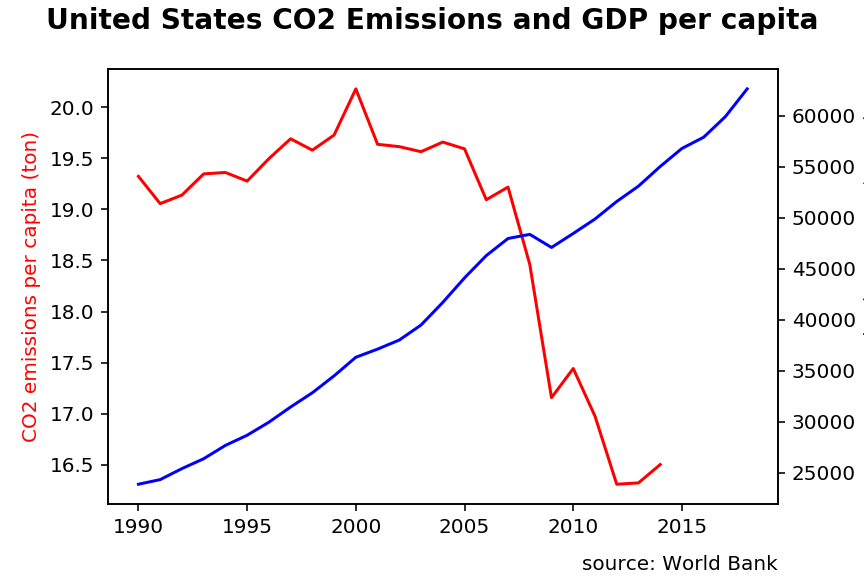

<IPython.core.display.Javascript object>

In [79]:
final = pn.Column(test.view_graph, test.param.country_name)

<IPython.core.display.Javascript object>

Column
    [0] ParamMethod(method)
    [1] Select(name='Country name', options=OrderedDict([('Afghanistan...]), value='Nicaragua')
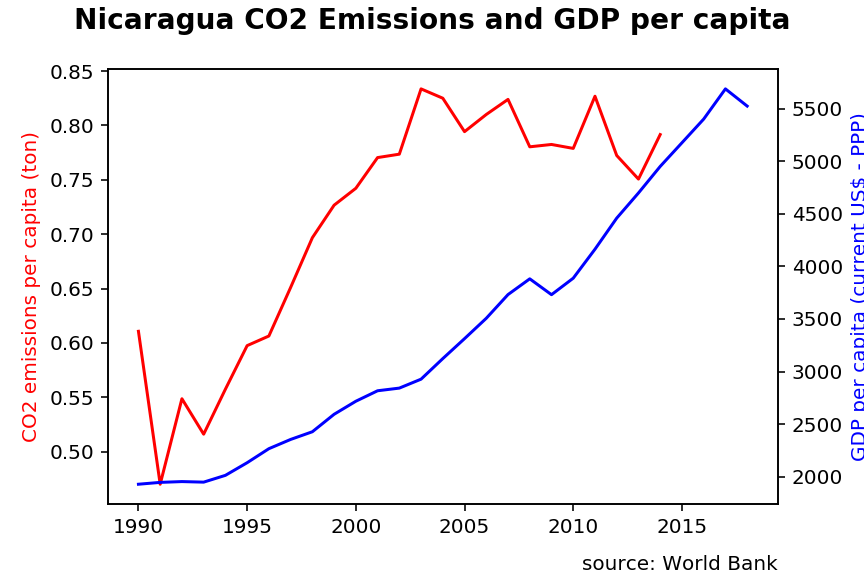

<IPython.core.display.Javascript object>

In [81]:
final

,Country Name,Country Code,year,GDP.MKTP,GDP.PCAP,CO2E.KT,CO2E.PC,GHGT.KT
182,United States,USA,1990,5.963144e+12,23888.600009,4823403.118,19.322751,6136093.5


<IPython.core.display.Javascript object>